# Data

We will analyse a data set of clinical features from various patients. We aim to set up a model to predict heart diseases. The dataset and some information about the features can be found here: https://www.kaggle.com/fedesoriano/heart-failure-prediction


# Imports

In [1]:
# Read in all necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Read in specific models and functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [3]:
df = pd.read_csv("heart.csv")

# Feature Analysis

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


We have a few categorical columns which we have to transform later. But first we can do a quick statistical analysis of the numerical features.

In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


We have zero values for RestingBP and Cholesterol. Since this is not possible we need to fix it by either dropping these columns or filling in reasonable values.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
Age               918 non-null int64
Sex               918 non-null object
ChestPainType     918 non-null object
RestingBP         918 non-null int64
Cholesterol       918 non-null int64
FastingBS         918 non-null int64
RestingECG        918 non-null object
MaxHR             918 non-null int64
ExerciseAngina    918 non-null object
Oldpeak           918 non-null float64
ST_Slope          918 non-null object
HeartDisease      918 non-null int64
dtypes: float64(1), int64(6), object(5)
memory usage: 86.1+ KB


There are no null-values in any column we have to handle.

## Encode categorical columns

In [7]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [8]:
df_encoded.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


In the next step we fix the unreasonable zero values of RestingBP and Cholesterol we noticed above.

In [9]:
df_encoded[df_encoded["RestingBP"] == 0]

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
449,55,0,0,0,155,1.5,1,1,0,1,0,1,0,0,1,0


Since there is only one person with RestingBP == 0 we will drop this row.

In [10]:
df_encoded = df_encoded[df_encoded["RestingBP"] > 0]

In [11]:
df_encoded[df_encoded["Cholesterol"] == 0].count()[0]

171

Dropping all these columns is not a good option, because we would loose an enormous part of our data.
To find a suitable value with which to replace the zeros, we first check whether the cholesterol value is strongly correlated with another feature.
For example, if it highly correlates with age, we could use the average values of cholesterol from defined age intervals.

In [12]:
df_encoded[df_encoded["Cholesterol"] > 0].corr()["Cholesterol"].sort_values().iloc[0:-1]

Sex_M               -0.107045
ST_Slope_Up         -0.099063
ChestPainType_NAP   -0.068441
ChestPainType_TA    -0.050253
RestingECG_Normal   -0.046950
RestingECG_ST       -0.028806
MaxHR               -0.019856
ChestPainType_ATA   -0.015945
FastingBS            0.054012
Oldpeak              0.058488
Age                  0.058758
ExerciseAngina_Y     0.086768
RestingBP            0.095939
HeartDisease         0.103866
ST_Slope_Flat        0.103996
Name: Cholesterol, dtype: float64

It looks like there is no feature highly correlated with Cholesterol. To be sure we view plots with the two features with the highest correlation.

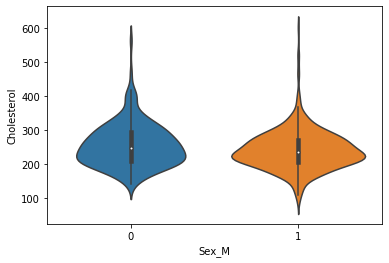

In [13]:
sns.violinplot(data=df_encoded[df_encoded["Cholesterol"]>0], x="Sex_M", y="Cholesterol")

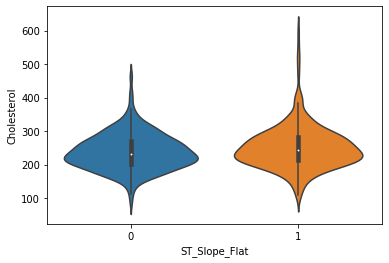

In [14]:
sns.violinplot(data=df_encoded[df_encoded["Cholesterol"]>0], x="ST_Slope_Flat", y="Cholesterol")

In either plot there is no significant trend visible. Probably the small differences are due to chance and the relatively small data set. We will not consider that further and use the average of the cholesterol value greater zero.

In [15]:
cholesterol_avg = df_encoded[df_encoded["Cholesterol"]>0].Cholesterol.mean()

In [16]:
df_encoded.Cholesterol = df_encoded.Cholesterol.replace({0: cholesterol_avg})

In [17]:
df_encoded[df_encoded["Cholesterol"] == 0].count()[0]

0

In the following part we want to calculate the correlation of the different features with having a heart disease or not.

In [18]:
corr_heart_disease = df_encoded.corr()["HeartDisease"].sort_values().iloc[0:-1]
corr_heart_disease

ST_Slope_Up         -0.621843
ChestPainType_ATA   -0.401680
MaxHR               -0.401410
ChestPainType_NAP   -0.215311
RestingECG_Normal   -0.092452
ChestPainType_TA    -0.054591
Cholesterol          0.094113
RestingECG_ST        0.103067
RestingBP            0.117990
FastingBS            0.267994
Age                  0.282012
Sex_M                0.305118
Oldpeak              0.403638
ExerciseAngina_Y     0.495490
ST_Slope_Flat        0.553700
Name: HeartDisease, dtype: float64

Text(0.5, 1.0, 'Feature Correlation to HeartDisease')

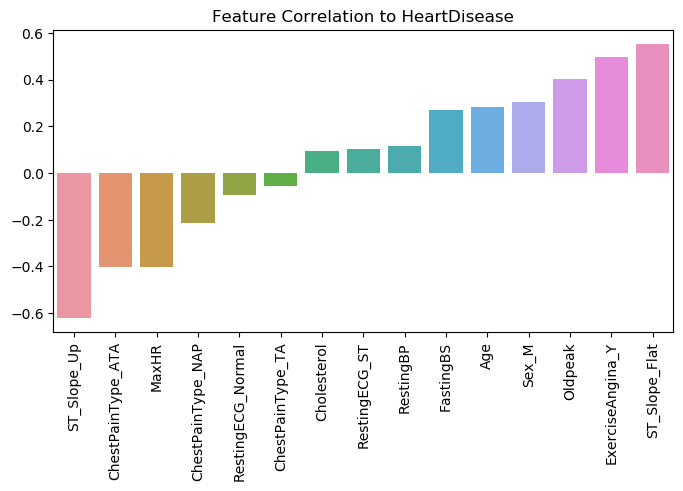

In [19]:
plt.figure(figsize=(8,4), dpi=100)
sns.barplot(x=corr_heart_disease.index, y=corr_heart_disease.values)
plt.xticks(rotation=90)
plt.title("Feature Correlation to HeartDisease")

Apparently ST_Slope has the greatest impact on suffering from heart disease in both expressions "Up" and "Flat". The numerical features with highest correlation are MaxHR and Oldpeak.

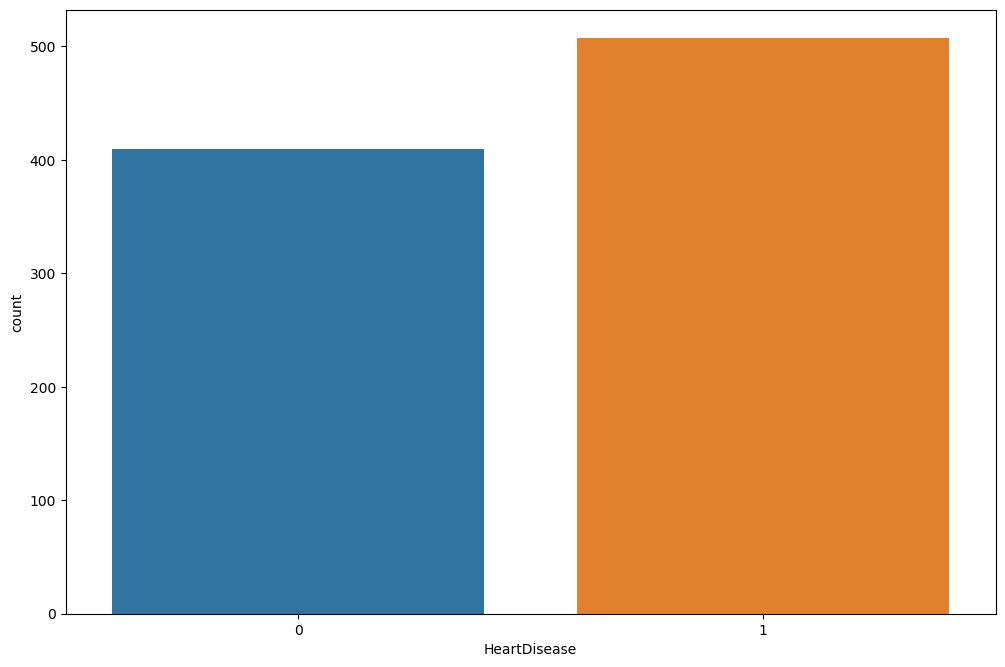

In [83]:
plt.figure(figsize=(12,8), dpi=100)
sns.countplot(data=df_encoded, x="HeartDisease")

The data is well balanced between the two classes, no further consideration is required.

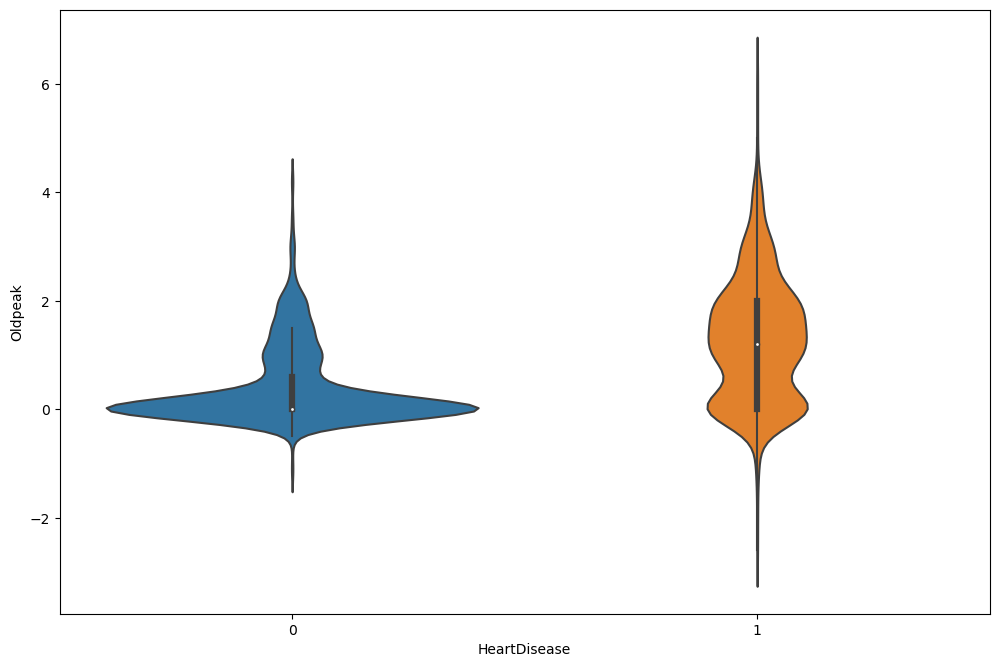

In [21]:
plt.figure(figsize=(12,8), dpi=100)
sns.violinplot(data=df_encoded, y="Oldpeak", x="HeartDisease")

Here one can already see a relatively clear distinction between the data sets with heart disease (right) and without (left). Without heart disease, a large part of the data is clustered around the value 0, while the data with heart disease tends to be larger and has a higher variance.

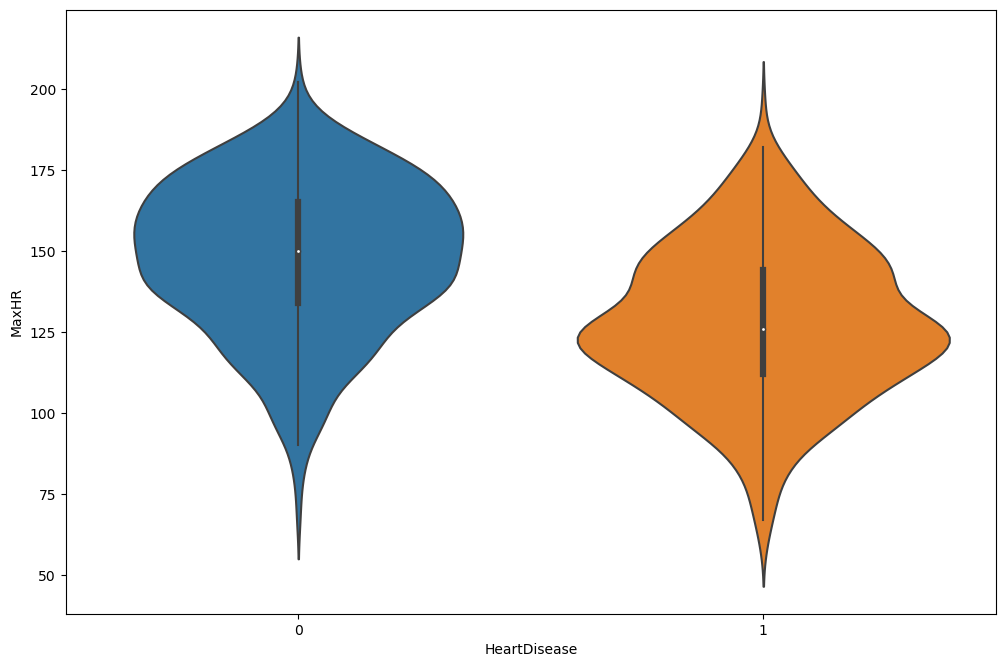

In [22]:
plt.figure(figsize=(12,8), dpi=100)
sns.violinplot(data=df_encoded, y="MaxHR", x="HeartDisease")

The feature MaxHR gives another hint on suffering from heart disease or not. The data without heart disease concentrates around a higher value than the data with heart disease.

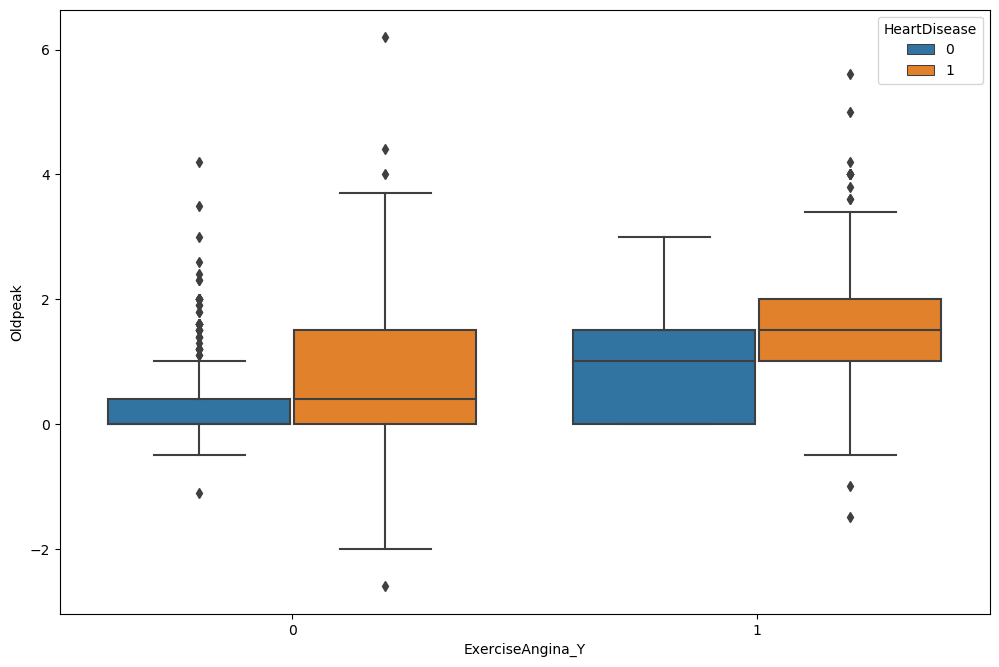

In [23]:
plt.figure(figsize=(12,8), dpi=100)
sns.boxplot(data=df_encoded, x="ExerciseAngina_Y", y="Oldpeak", hue="HeartDisease")

In this plot we can see the impact of the combination of Oldpeak and ExerciseAngina on suffering from heart disease. The data without heart disease and exercise induced angina is clustered very dense around 0 but has a lot of outliers. Compared to that, the data with heart disease and without exercise induced angina tends to have higher values and spreading in Oldpeak. The data with exercise induced angina behaves somewhat differently. Here, the data without heart disease also tends to be smaller, but this time has a high variance. The data with heart disease, on the other hand, lies closely around one value.

# Train Test Split

Now we divide the data into a training and a testing set. For training we will use 80% of the data. We will set up different models to classify the data and compare the performance.
The procedure is similar for all models. We select the parameters to be tested via GridSearchCV. With the best parameters we then try to predict which patients from the test set have a heart disease.

In [24]:
X = df_encoded.drop(["HeartDisease"], axis=1)
y = df_encoded["HeartDisease"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

## Random Forest Classifier

In [26]:
rfc_model = RandomForestClassifier(random_state=23)

In [27]:
param_grid_rfc = {"n_estimators":[50,100,125,150,200],
                  "max_features":[2,3,4],
                  "oob_score":[True,False]}

In [28]:
grid_rfc = GridSearchCV(rfc_model, param_grid_rfc, cv=5)

In [29]:
grid_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=23),
             param_grid={'max_features': [2, 3, 4],
                         'n_estimators': [50, 100, 125, 150, 200],
                         'oob_score': [True, False]})

In [30]:
grid_rfc.best_params_

{'max_features': 2, 'n_estimators': 50, 'oob_score': True}

In [31]:
y_pred_rfc = grid_rfc.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83        83
           1       0.86      0.88      0.87       101

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



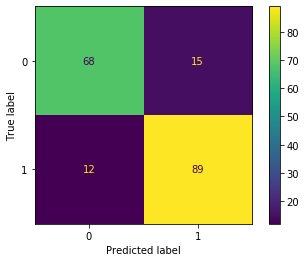

In [65]:
plot_confusion_matrix(grid_rfc, X_test, y_test)

## AdaBoost

In [66]:
ab_model = AdaBoostClassifier(random_state=23)

In [67]:
param_grid_ab = {"n_estimators":[1,5,10,13,15,17,20,40]}

In [68]:
grid_ab = GridSearchCV(ab_model, param_grid_ab, cv=5)

In [69]:
grid_ab.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=23),
             param_grid={'n_estimators': [1, 5, 10, 13, 15, 17, 20, 40]})

In [70]:
grid_ab.best_params_

{'n_estimators': 10}

In [71]:
y_pred_ab = grid_ab.predict(X_test)

In [72]:
print(classification_report(y_test, y_pred_ab))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82        83
           1       0.85      0.86      0.86       101

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



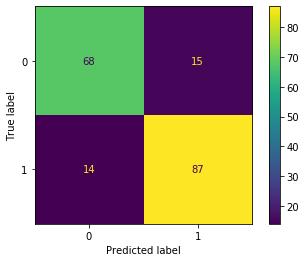

In [73]:
plot_confusion_matrix(grid_ab, X_test, y_test)

## Gradient Boosting

In [74]:
param_grid_gb = {"n_estimators":[1,5,10,20,40,100,125,150],
                 'max_depth':[2,3,4,5,6]}

In [75]:
gb_model  = GradientBoostingClassifier(random_state=23)

In [76]:
grid_gb = GridSearchCV(gb_model, param_grid_gb, cv=5)

In [77]:
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=23),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [1, 5, 10, 20, 40, 100, 125, 150]})

In [78]:
grid_gb.best_params_

{'max_depth': 2, 'n_estimators': 100}

In [79]:
y_pred_gb = grid_gb.predict(X_test)

In [80]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85        83
           1       0.85      0.92      0.89       101

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184



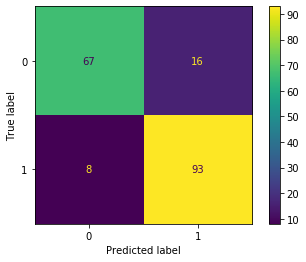

In [81]:
plot_confusion_matrix(grid_gb, X_test, y_test)

## XGBoost

In [49]:
xgb_model = XGBClassifier(random_state=23, use_label_encoder=False, eval_metric="logloss")

In [56]:
param_grid_xgb = {'min_child_weight': [1, 5, 10, 15, 20],
                  'gamma': [0.5, 1, 1.5, 2, 3, 5],
                  'subsample': [0.6, 0.8, 1.0],
                  'colsample_bytree': [0.6, 0.8, 1.0],
                  'max_depth': [3, 4, 5]}

In [57]:
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5)

In [58]:
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...obs=None,
                                     num_parallel_tree=None, random_state=23,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
             

In [59]:
grid_xgb.best_params_

{'colsample_bytree': 0.6,
 'gamma': 3,
 'max_depth': 4,
 'min_child_weight': 5,
 'subsample': 1.0}

In [60]:
y_pred_xgb = grid_xgb.predict(X_test)

In [61]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        83
           1       0.85      0.92      0.88       101

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



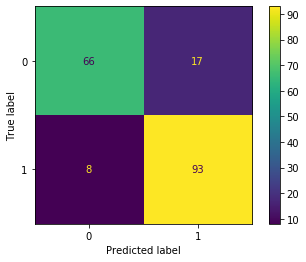

In [62]:
plot_confusion_matrix(grid_xgb, X_test, y_test)

Since we want to predict as many heart diseases as possible correctly, the recall for 1 is the key ratio for us. Therefore, we should choose either GB or XGBoost, which achieve a very good score of 92%. The GB-Model has a slightly better accuracy and f1-score. Overall, however, it must be noted that there are minor fluctuations in all ratios depending on the random state due to the small amount of data.